#  Inert doublet model

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import os, sys, inspect
import commands
from hep import *

Define functions to change from general basis to physical basis 

In [3]:
def run_official_idm(MHX,MH3,MHC,laL,la2,Mh,check=False):
    pd.Series({'MHX':MHX,'MH3':MH3,'MHC':MHC,'laL':laL,'la2':la2,'Mh':Mh}).to_csv('mo.dat',sep=' ')
    omegah2=-1
    if os.path.isfile('../micromegas/IDM/main'):
        mo=commands.getoutput("../micromegas/IDM/main mo.dat")
        
    return mo

def phys_to_int(mH,mA,mHc,lambda_L,v):
    mH2=mH*mH;mA2=mA*mA;mHc2=mHc*mHc;v2=v*v
    lambda_5=(mH2-mA2)/v2
    mu2=mH2-lambda_L*v2
    lambda_3=2.*(mHc2-mu2)/v2
    lambda_4=-lambda_3-lambda_5+2*lambda_L
    return mu2,lambda_3,lambda_4,lambda_5

def int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v):
    v2=v*v
    tachyons=False
    mHc2=mu2+lambda_3*v2/2.
    if mHc2<0: tachyons=True
    mH2=mu2+(lambda_3+lambda_4+lambda_5)*v2/2.
    if mH2<0: tachyons=True
    mA2=mu2+(lambda_3+lambda_4-lambda_5)*v2/2.
    if mA2<0: tachyons=True
    if tachyons: print "Warning: Tachyionic masses"
    return np.sqrt(np.abs(np.array([mH2,mA2,mHc2]))),(lambda_3+lambda_4+lambda_5)/2 

Define function to run official micromegas IDM

In [4]:
def run_official_idm_lha(spc,check=False):
    laL=(spc.blocks['MINPAR'][3]+spc.blocks['MINPAR'][4]+spc.blocks['MINPAR'][5])/2.
    MHX=spc.blocks['MASS'][35];MH3=spc.blocks['MASS'][36];MHC=spc.blocks['MASS'][37]
    la2=spc.blocks['MINPAR'][2];Mh=spc.blocks['MASS'][25]
    return run_official_idm(MHX,MH3,MHC,laL,la2,Mh,check=check)



## Check one point

In [5]:
a=hep(MODEL='SimplifiedDMIDM')

In [7]:
v=a.vev
ipt=np.array([40,120,120,0.1])
mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt[0],ipt[1],ipt[2],ipt[3],v)
print 'expected:',ipt
print 'obtained:',int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v)
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lambda_3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lambda_4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
moc=a.runmicromegas(Direct_Detection=True)
print 'Omega h^2 =',a.Series.Omega_h2
#spc.blocks['MASS'].entries
#TODO: Change PDF of scalar sector in both scotogenic and IDM

expected: [  4.00000000e+01   1.20000000e+02   1.20000000e+02   1.00000000e-01]
obtained: (array([  40.,  120.,  120.]), 0.10000000000000002)
Omega h^2 = 4.63


In [8]:
omhof=run_official_idm_lha(a.LHA_out,check=True)
omo=a.micromegas_output(omhof)
print 'Omega h^2 =',a.Series.Omega_h2

Omega h^2 = 4.63


## Scan $m_{H^0}$

In [11]:
df=pd.DataFrame()
ipt=pd.Series({'MHX':40,'MH3':701,'MHC':701,'lambda_L':0.1})
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
dm_masses=np.linspace(40,700,10)
for MHX in dm_masses:
    if np.where(dm_masses==MHX)[0][0]%10==0: #find the index of the array entry
        print np.where(dm_masses==MHX)[0][0]
    ipt.MHX=MHX
    mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,a.vev)
    a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
    a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda4Input' %lambda_3
    a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda3Input' %lambda_4
    a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
    a.runmicromegas(Direct_Detection=True)
    a.Series=a.Series.append(ipt)
    a.Series=a.Series.append(pd.Series({'MH0':a.LHA_out.blocks['MASS'][35],\
                                        'MA0':a.LHA_out.blocks['MASS'][36],\
                                        'MHc':a.LHA_out.blocks['MASS'][37]}))
    omhof=run_official_idm_lha(a.LHA_out,check=True)
    omo=a.micromegas_output(omhof)
    a.Series['Omega_h2_official']=omo.Omega_h2
    a.Series['proton_SI_official']=omo.proton.SI
    a.Series['neutron_SI_official']=omo.neutron.SI
    df=df.append(a.Series,ignore_index=True)

0


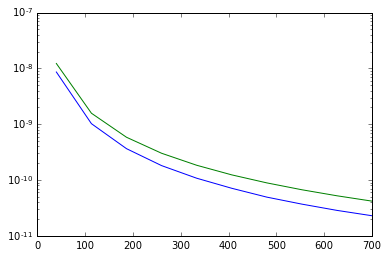

In [12]:
dfm=df[df.MH0<df.MHc]
plt.semilogy(dfm.MH0,dfm.proton_SI)
plt.semilogy(dfm.MH0,dfm.proton_SI_official)

In [ ]:
df=pd.DataFrame()
ipt=pd.Series({'MHX':40,'MH3':120,'MHC':120,'lambda_L':0.1})
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
dm_masses=np.linspace(90,700,10)
for MHX in dm_masses:
    if np.where(dm_masses==MHX)[0][0]%10==0: #find the index of the array entry
        print np.where(dm_masses==MHX)[0][0]
    ipt.MHX=MHX
    ipt.MH3=MHX
    ipt.MHC=MHX
    mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt.MHX,ipt.MH3,ipt.MHC,ipt.lambda_L,a.vev)
    a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
    a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda4Input' %lambda_3
    a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda3Input' %lambda_4
    a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
    a.runmicromegas(Direct_Detection=True)
    a.Series=a.Series.append(ipt)
    a.Series=a.Series.append(pd.Series({'MH0':a.LHA_out.blocks['MASS'][35],\
                                        'MA0':a.LHA_out.blocks['MASS'][36],\
                                        'MHc':a.LHA_out.blocks['MASS'][37]}))
    omhof=run_official_idm_lha(a.LHA_out,check=True)
    omo=a.micromegas_output(omhof)
    a.Series['Omega_h2_official']=omo.Omega_h2
    a.Series['proton_SI_official']=omo.proton.SI
    a.Series['neutron_SI_official']=omo.neutron.SI
    df=df.append(a.Series,ignore_index=True)

In [19]:
v=a.vev
mc=600
ipt=np.array([mc,mc,mc,0.1])
mu2,lambda_3,lambda_4,lambda_5=phys_to_int(ipt[0],ipt[1],ipt[2],ipt[3],v)
print 'expected:',ipt
print 'obtained:',int_to_phys(mu2,lambda_3,lambda_4,lambda_5,v)
devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
a.LHA.blocks['MINPAR'][3]='%0.8E       #lambda3Input' %lambda_3
a.LHA.blocks['MINPAR'][4]='%0.8E       #lambda4Input' %lambda_4
a.LHA.blocks['MINPAR'][5]='%0.8E       #lambda5Input' %lambda_5
a.LHA.blocks['MINPAR'][6]='%0.8E       #mEt2Input' %mu2
moc=a.runmicromegas(Direct_Detection=True)
print 'Omega h^2 =',a.Series.Omega_h2,a.Series.proton_SI
#spc.blocks['MASS'].entries
#TODO: Change PDF of scalar sector in both scotogenic and IDM

expected: [  6.00000000e+02   6.00000000e+02   6.00000000e+02   1.00000000e-01]
obtained: (array([ 600.,  600.,  600.]), 0.10000000000000001)
Omega h^2 = 0.109 5.599e-05


In [18]:
omhof=run_official_idm_lha(a.LHA_out,check=True)
omo=a.micromegas_output(omhof)
print 'Omega h^2 =',a.Series.Omega_h2,a.Series.proton_SI

Omega h^2 = 0.00325 5.331e-05


In [19]:
a.Series

GFFermiconstant       0.000012
Zbosonpolemass       91.188700
alphasMZSMMSbar       0.118700
lambda1               0.267000
lambda2               0.000000
lambda3               0.200000
lambda4               0.000000
lambda5               0.000000
mEt2               3937.543140
mbmbSMMSbar           4.180000
mtaupole              1.776690
mtoppole            173.500000
Omega_h2              0.003250
proton_SI             0.000053
neutron_SI            0.002433
dtype: float64